In [1]:
import os
from glob import glob

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Problem 1

Please implement an edge detector using the discrete Laplacian operator as 
presented in Lecture 04. From the Internet, download an image of a cat and produce an 
image of edges. Create a Laplacian matrix, format your image as one matrix (for 
simplicity, use one channel, not three) and literarily scan the image matrix with the 
Laplacian. At every stop calculate element wise product of the Laplacian and the area of 
the image below it. Present the resulting matrix as an image.  
(25%)

### Part 1: Implement an Edge Detector Using Discrete Laplacian Operator

In [2]:
def detect_edges(input_array, kernel=None, pad_input=False):
    # create the kernel if none is provided
    if kernel is None:
        kernel = np.array([
            [-1, -1, -1],
            [-1,  8, -1],
            [-1, -1, -1]
        ])
        
    # pad input with zeros if required
    padded_input = (
        np.pad(input_array, pad_width=1, mode='constant', constant_values=0)
        if pad_input 
        else input_array
    )
    
    k_rows, k_cols = kernel.shape
    i_rows, i_cols = padded_input.shape
    
    # compute the indices for sliding kernel over the input array
    rows = i_rows - k_rows + 1
    cols = i_cols - k_cols + 1
    
    # place holder for the result of the element-wise multiplication
    result = np.empty((rows, cols), dtype=padded_input.dtype)
    
    # slide kernel over the input array, left to right, then top to bottom
    for row in range(rows):
        for col in range(cols):
            # perform element-wise multiplication
            window = padded_input[row:row + k_rows, col:col + k_cols]
            result[row, col] = np.sum(window * kernel)
        
    return result

In [3]:
def read_normalize_image(image_path):
    """Reads an normalize image from disk"""
    img = Image.open(image_path).convert("L").resize((28, 28))
    img = np.array(img, dtype=np.float32) / 255.0
    return img

In [4]:
input_array = np.array([
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

result = detect_edges(input_array)
result

array([[-2,  6, -2],
       [ 7, -2, -1],
       [-1, -1,  0]])

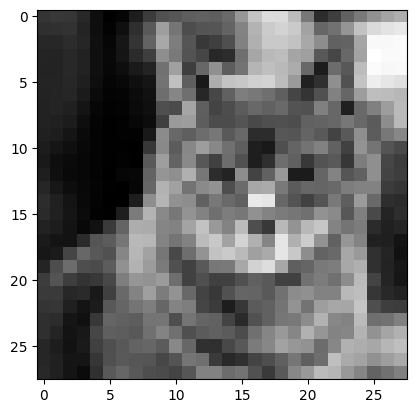

In [5]:
cat_img = read_normalize_image('images/cat5.png')
plt.imshow(cat_img, cmap="gray")
plt.show()

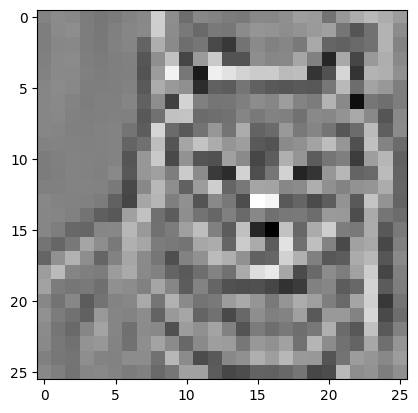

In [6]:
scanned_image = detect_edges(cat_img, pad_input=False)
plt.imshow(scanned_image, cmap="gray")
plt.show()


# Problem 2. 

Modify kernel size in the second convolutional layer in the CNN for 
Classification of MNIST Images as defined on slide 55 of the lecture notes. Let the 
second and the third Convolution layers use kernel size of (4,4). For the first layer keep 
kernel size of (3,3). Print the summary of your model. Please provide detailed 
explanation (calculation) for all numbers of trainable parameters.  
(25%) 

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import (
    layers,
    models,
    Input
)

In [8]:
def cnn_model(
    input_shape=(28, 28, 1), 
    kernel_layer1=(3, 3), 
    kernel_layer2=(4, 4),
    kernel_layer3=(4, 4)
):
    model = models.Sequential()
    model.add(Input(shape=input_shape))
    model.add(layers.Conv2D(32,kernel_layer1,activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, kernel_layer2, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, kernel_layer3, activation='relu'))
    
    return model

In [9]:
model = cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 64)       │        65,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,752 (385.75 KB)

 Trainable params: 98,752 (385.75 KB)

 Non-trainable params: 0 (0.00 B)

Explanation of the Model Summary:

# Problem 3

For the model presented in the notebook 5.1-introduction-to-
convnets.ipynb, change the size of the kernel on the first convolutional layer from 
3x3 to 4x4, then to 5x5 and finally 6x6. Run the training each time. Record and report the 
accuracy for different filter sizes. Plot the evolution of accuracy with epoch for every 
change. Select the best model. Next change the batch size to 32, then 128 and see the 
impact on the number of batches per epoch. What impact does this have on accuracy ? 
We learnt about callbacks , implement callback function for CSVlogger where all 
information from Epochs will be logged in to a CSV.

Prepare Training Data

In [10]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Scale images to the [0, 1] range
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# convert class vectors to binary class matrices
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [11]:
def attach_dense_classifier(model):
    """Feeds the output tensor of the model into a densely-connected classifier network"""
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

In [12]:
def compile_train(model, filename, batch_size=64):
    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    callback_csvlogger = keras.callbacks.CSVLogger(
        filename=filename
    )
    return model.fit(
        train_images, 
        train_labels, 
        epochs=5, 
        batch_size=batch_size, 
        callbacks=[callback_csvlogger]
    )

In [13]:
def train_and_evaluate_model(
    filename,
    input_shape=(28, 28, 1), 
    kernel_layer1=(3, 3), 
    kernel_layer2=(3, 3),
    kernel_layer3=(3, 3),
    batch_size=64
):
    model = cnn_model(
        input_shape=input_shape,
        kernel_layer1=kernel_layer1,
        kernel_layer2=kernel_layer2,
        kernel_layer3=kernel_layer3,
    )
    attach_dense_classifier(model)
    history = compile_train(
        model=model, 
        filename=filename, 
        batch_size=batch_size
    )
    result = model.evaluate(test_images, test_labels)
    return model, history, result

Part 1: Use 4,4 Kernel on the First Convolutional Layer

In [14]:
_, history, result = train_and_evaluate_model(
    'data/kernel_4_4_first_layer.csv', 
    kernel_layer1=(4, 4)
)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9451 - loss: 0.1773
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9857 - loss: 0.0463
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9901 - loss: 0.0321
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9925 - loss: 0.0244
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9942 - loss: 0.0190
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9917 - loss: 0.0272


In [15]:
result

[0.02722480520606041, 0.9916999936103821]

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss'])

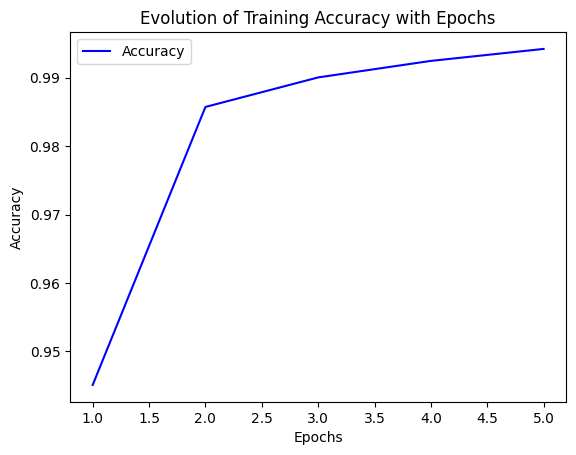

In [17]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Evolution of Training Accuracy with Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Part 2: Use 5, 5 Kernel on the First Convolutional Layer

In [18]:
_, history, result = train_and_evaluate_model(
    'data/kernel_5_5_first_layer.csv', 
    kernel_layer1=(5, 5)
)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9462 - loss: 0.1721
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9851 - loss: 0.0473
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9897 - loss: 0.0331
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9922 - loss: 0.0262
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9939 - loss: 0.0206
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9924 - loss: 0.0256


In [19]:
result

[0.025633541867136955, 0.9923999905586243]

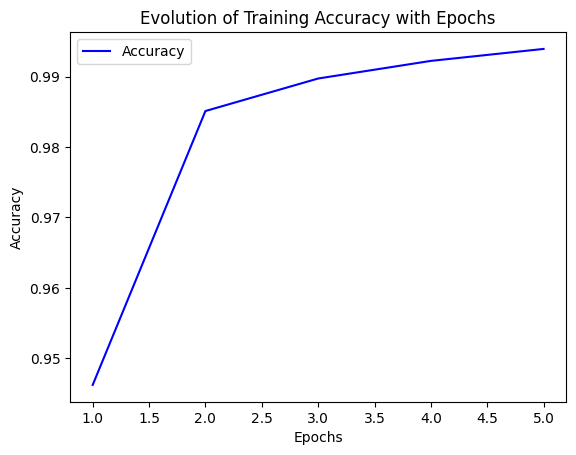

In [20]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Evolution of Training Accuracy with Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Part 3: Use 6, 6 Kernel on the First Convolutional Layer

In [21]:
_, history, result = train_and_evaluate_model(
    'data/kernel_6_6_first_layer.csv', 
    kernel_layer1=(6, 6)
)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9348 - loss: 0.2070
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9828 - loss: 0.0552
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9882 - loss: 0.0384
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9912 - loss: 0.0293
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9925 - loss: 0.0252
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9902 - loss: 0.0337


In [22]:
result

[0.03370239585638046, 0.9901999831199646]

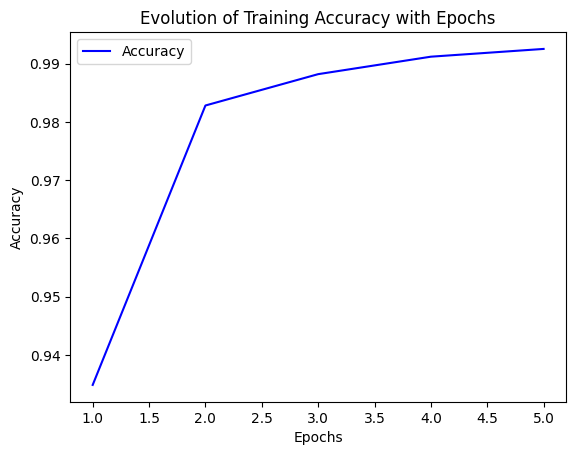

In [23]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Evolution of Training Accuracy with Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The 3 models achieved an accuracy of ~92% with models 1 (with 4, 4 kernel) and 2 (with 5, 5 kernel) slightly out-performing model 3 (with 6, 6 kernel). I will be choosing model 1 as my best model because it has a relatively smaller kernel because it could have a lower processing time.

Part 4: Use 4, 4 Kernel on the First Convolutional Layer with a Batch Size of 32

In [24]:
_, history, result = train_and_evaluate_model(
    'data/kernel_4_4_first_layer_batch32.csv', 
    kernel_layer1=(4, 4),
    batch_size=32
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9572 - loss: 0.1379
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9862 - loss: 0.0438
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9907 - loss: 0.0307
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9925 - loss: 0.0244
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9940 - loss: 0.0195
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9920 - loss: 0.0308


In [25]:
result

[0.030831405892968178, 0.9919999837875366]

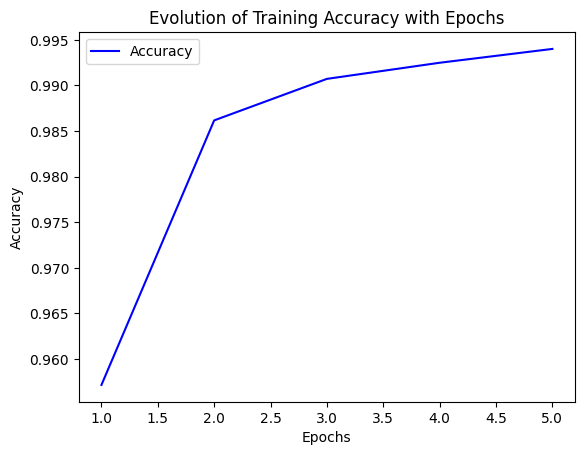

In [26]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Evolution of Training Accuracy with Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

By changing the batch size of the best model from 64 to 32, the model's performance improved slightly from 99.2% to 99.3%

Part 5: Use 4, 4 Kernel on the First Convolutional Layer with a Batch Size of 128

In [27]:
_, history, result = train_and_evaluate_model(
    'data/kernel_4_4_first_layer_batch128.csv', 
    kernel_layer1=(4, 4),
    batch_size=128
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9260 - loss: 0.2355
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9829 - loss: 0.0548
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9888 - loss: 0.0363
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9912 - loss: 0.0284
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9935 - loss: 0.0218
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - loss: 0.0344


In [28]:
result

[0.03435862064361572, 0.9889000058174133]

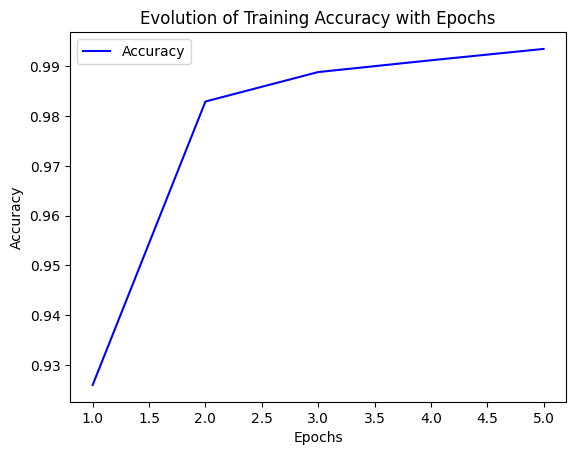

In [29]:
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Accuracy')
plt.title('Evolution of Training Accuracy with Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

By changing the batch size of the best model from 64 to 128, the model achieves the same performance as the 64 batch size but slightly lower than 32 batch size (99.3%). 
In conclusion, with a batch size of 32 our best performing model slightly outperforms the same model with a batch size of 64 and 128.

# Problem 4
 
Use your own handwriting to create 2 images each of numbers 0,1,2,3, 4. 
Test the ability of the best model selected in problem 3 to recognize those numbers. 
Assess the accuracy of the model using just those 18 digits as the test set. Compare with 
the result of problem 3. 
(20%)

In [30]:
def load_digits_data(src_path):
    # process digits images if not already processed
    images = []
    labels = []
    
    file_paths = glob(os.path.join(src_path, "0*"))
    for file_path in file_paths:
        try:
            label = int(os.path.basename(file_path)[:2])
            labels.append(label)
            
            img = read_normalize_image(file_path)
            images.append(img)
        except Exception as e:
            print(f"skipping {file_path}: {e}")
            
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [31]:
model, _, _ = train_and_evaluate_model(
    'data/kernel_4_4_first_layer_digits.csv', 
    kernel_layer1=(4, 4),
    batch_size=32
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9548 - loss: 0.1423
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9868 - loss: 0.0451
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9905 - loss: 0.0313
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9922 - loss: 0.0253
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9941 - loss: 0.0206
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9901 - loss: 0.0388


In [ ]:
# load handwritten images
x_test, y_test = load_digits_data("images")
x_test = x_test.reshape((20, 28, 28, 1))

In [33]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


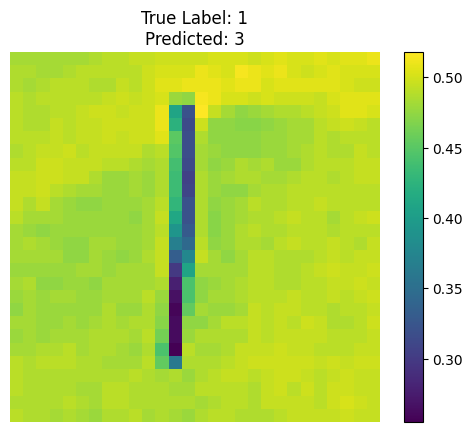

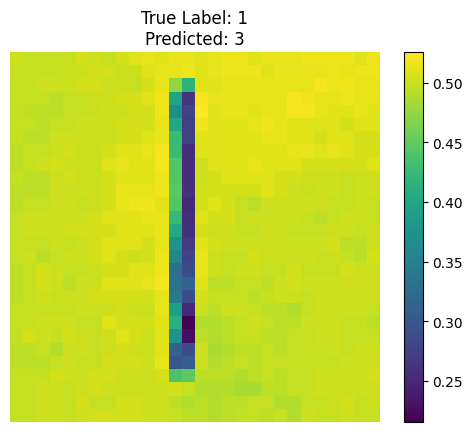

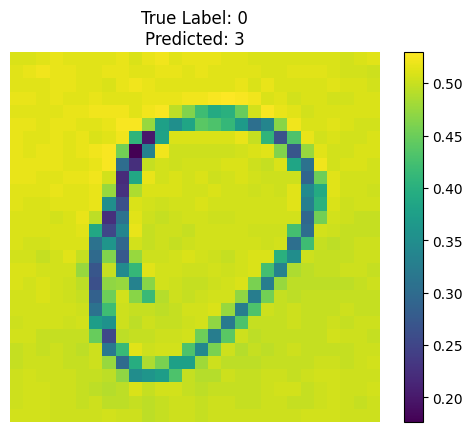

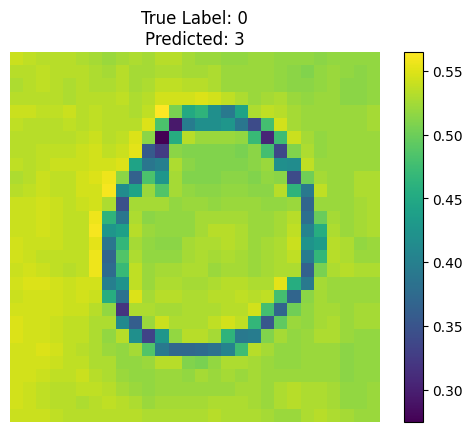

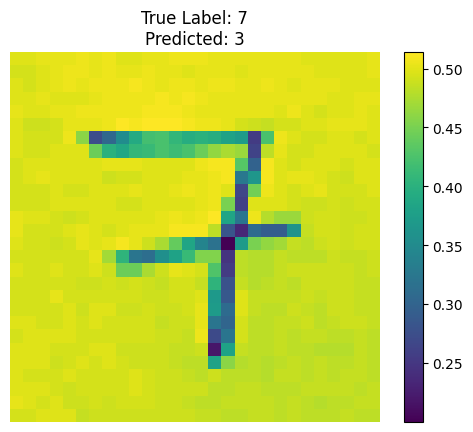

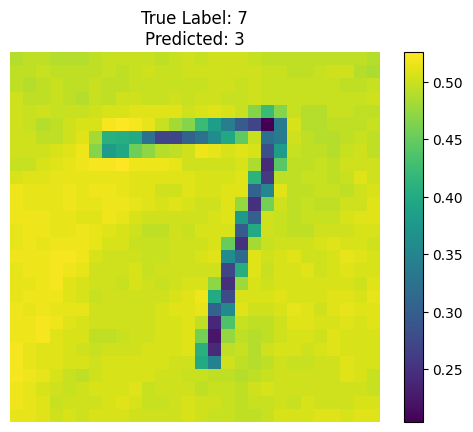

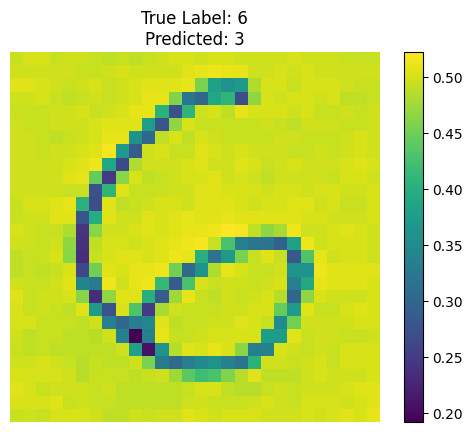

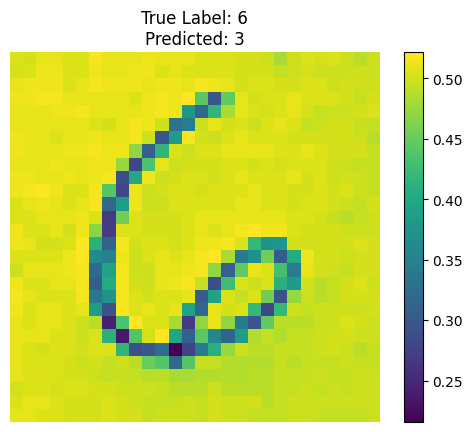

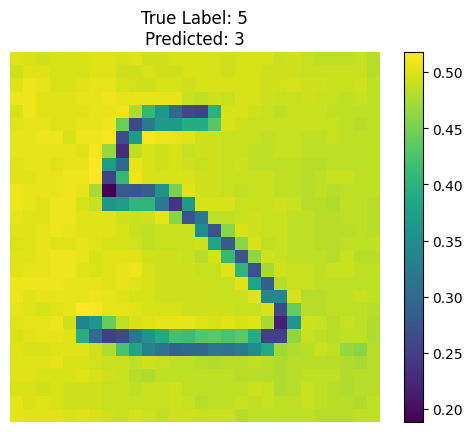

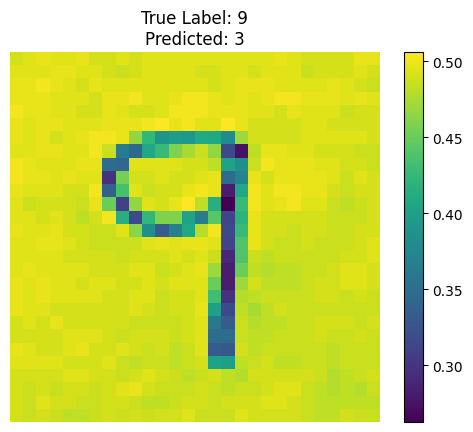

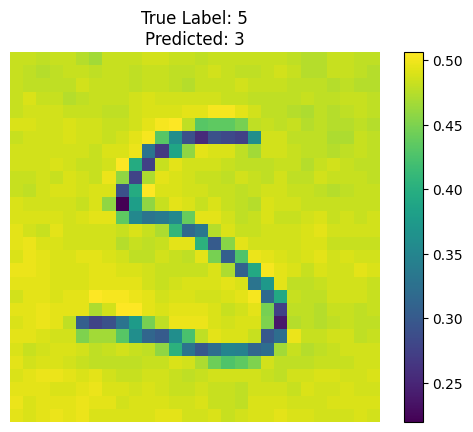

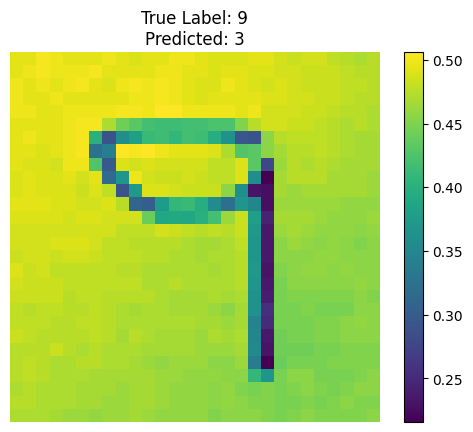

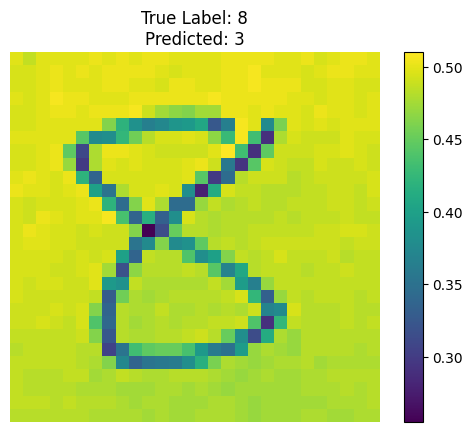

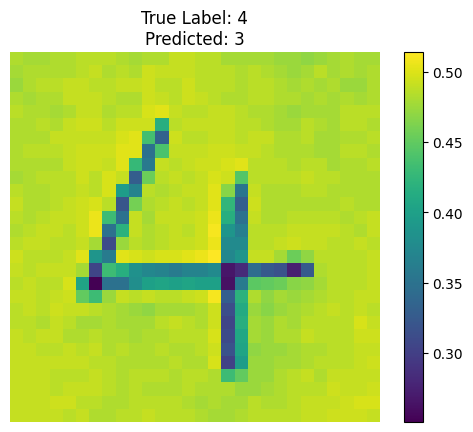

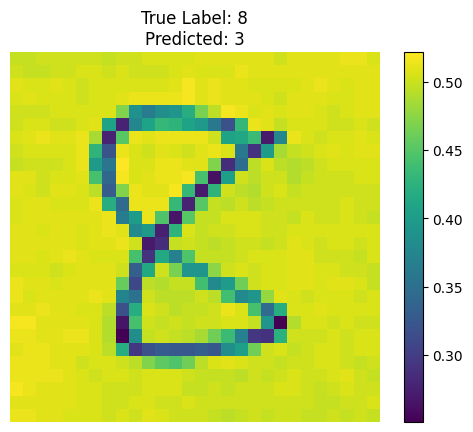

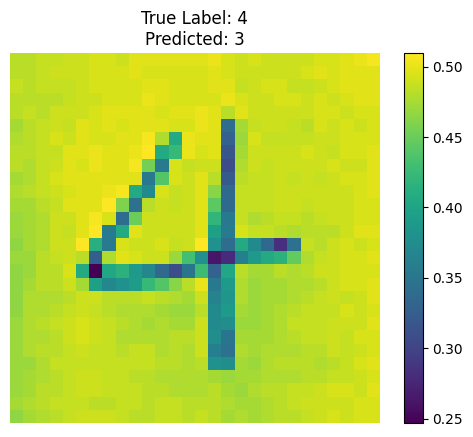

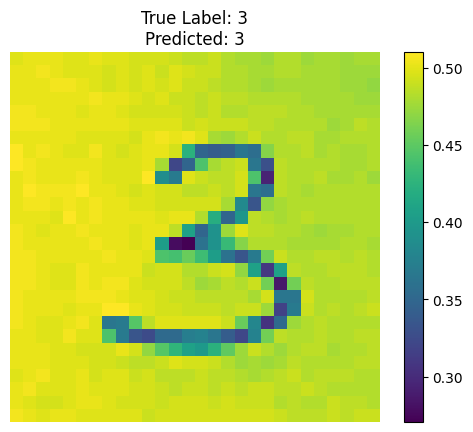

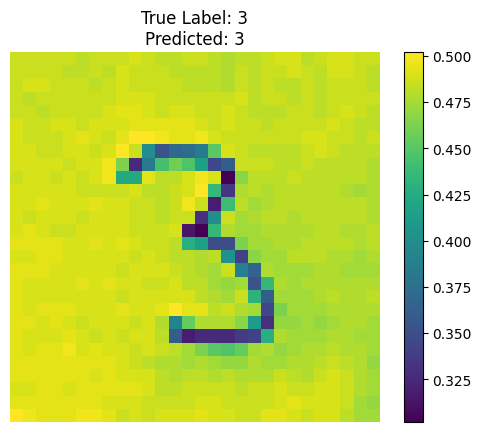

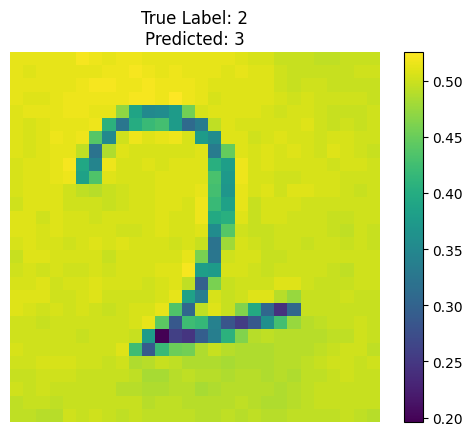

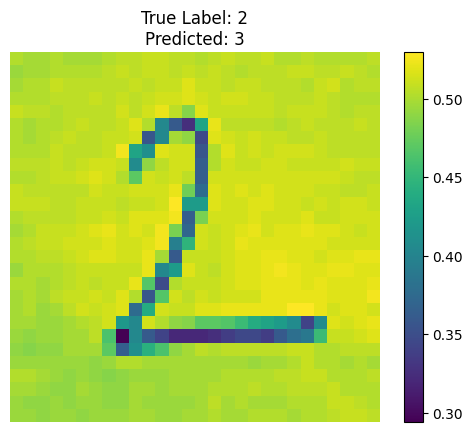

In [34]:
for index in range(len(y_test)):
    plt.figure()
    plt.imshow(x_test[index])
    plt.title(f"True Label: {y_test[index]}\nPredicted: {predictions[index]}")
    plt.axis('off')
    plt.colorbar()
    plt.grid(False)
    plt.show()